In [486]:
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import control as ct
import control.matlab as ctm
import random as rr
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

### Funções auxiliares

In [487]:
def moving_average(v, jan):
    vet = []
    s = 0
    for i in range(0, jan):
        s += v[i]
        vet.append(s/(i+1))      
    for j in range(jan, len(v)):
        s -= v[j - jan]
        s += v[j]
        med = s / jan
        vet.append(med)
    return vet

In [488]:
def NMRSE(medidos, estimados):
    n = len(medidos)
    s = 0
    media = 0

    for i in range(0, n):
        d = medidos[i] - estimados[i]
        s += d * d
        media += medidos[i]
        
    media /= n
    sroot = math.sqrt(s / n)
    x = sroot / media
    return 1 - x

In [489]:
def rsquared(medidos, estimados):
    n = len(medidos)
    sq_erro = 0
    sq_total = 0
    x_aux = 0
    x1_aux = 0
    
    for i in range(0, n):
        d = medidos[i] - estimados[i]
        sq_erro += d * d
        x_aux += medidos[i] ** 2
        x1_aux += medidos[i]

    x1_aux *= x1_aux
    sq_total = x_aux - x1_aux / n
    
    return 1 - sq_erro / sq_total

In [490]:
def pearson(medidos, estimados):
    n = len(medidos)
    x_barra = 0
    y_barra = 0
    for i in range(0, n):
        x_barra += medidos[i]
        y_barra += estimados[i]
    x_barra /= n
    y_barra /= n

    s = 0
    sx = 0
    sy = 0
    for i in range(0, n):
        dx = medidos[i] - x_barra
        dy = estimados[i] - y_barra
        s += dx * dy
        sx += dx * dx
        sy += dy * dy
    sx = math.sqrt(sx)
    sy = math.sqrt(sy)
    
    return s / (sx * sy)

In [491]:
def acha_idx(val, vet):
    c = 0
    best = 1e9
    ans = 0
    for x in vet:
        diff = abs(x - val)
        if diff < best:
            best = diff
            ans = c
        c += 1
    return ans

In [492]:
def calcula_estatistica(medidos, estimados):
    print('NMRSE = ', NMRSE(medidos, estimados))
    print('r2 = ', rsquared(medidos, estimados))
    print('pearson = ', pearson(medidos, estimados))

In [493]:
ESTADO_PERMANENTE = .8
AMP_DEGRAU = .8
TEMPO_AMOSTRAGEM = .3
TEMPO_TOTAL = 15
TEMPO_SIMULACAO = TEMPO_TOTAL - 3

In [494]:
def plotarGraficos(temp, amp, useft, usefv, NAME):
    plt.step(temp, amp, label=NAME)
    plt.step(useft, usefv)
    plt.plot(temp, [AMP_DEGRAU] * len(temp))
    plt.title('Resultado simulacao modelo ' + NAME)
    plt.legend([NAME, 'Coletado', 'Degrau'])
    plt.ylabel('Amplitude (V)')
    plt.xlabel('Tempo (s)')
    plt.grid(1)

In [495]:
def clean(num):
    num = re.sub(r'\n','', num)
    return float(num)

### Obtendo tempo de amostragem ideal

In [496]:
with open ('amostragem/valores.txt') as f:
    line = f.readlines()
    val_001 = list(map(clean, line))
len(val_001)

6668

In [497]:
with open ('amostragem/tempo.txt') as f:
    line = f.readlines()
    t_001 = list(map(clean, line))
len(t_001)

6668

In [498]:
val_001 = [val_001[i] for i in range(len(t_001)) if t_001[i] >= 3]
len(val_001)

4668

In [499]:
t_001 = [t_001[i] - 3 for i in range(len(t_001)) if t_001[i] >= 3]
len(t_001)

4668

In [500]:
val_001 = moving_average(val_001, 4)

In [501]:
v95 = .95*AMP_DEGRAU
idx = acha_idx(v95, val_001)
t95 =  t_001[idx]
idx, val_001[idx], t95

(1427, 0.7600175, 2.1399999999999997)

In [502]:
lower_t95 = t95/15
upper_t95 = t95/5
lower_t95, upper_t95

(0.14266666666666664, 0.42799999999999994)

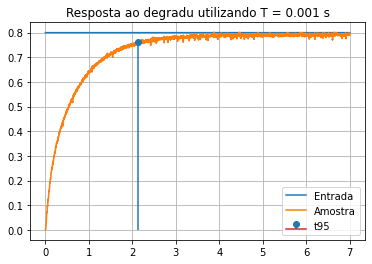

In [503]:
plt.plot(t_001, len(t_001)*[.8], label='Entrada')
plt.step(t_001, val_001, label='Amostra')
plt.stem(t_001[idx], val_001[idx], label='t95')
plt.title('Resposta ao degradu utilizando T = 0.001 s')
plt.legend()
plt.grid()
plt.show()

### Leitura dos arquivos de entrada

In [504]:
t = [.3*x for x in range(0, round(15.3/.3), 1)]

In [505]:
with open ('amostragem/values_0.3s.txt') as f:
    line = f.readlines()
    val = list(map(clean, line[0].split(',')))
print(val)
len(val)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37634, 0.53275, 0.61095, 0.6696, 0.7087, 0.7478, 0.76246, 0.77224, 0.77713, 0.77224, 0.77224, 0.77713, 0.79179, 0.79179, 0.7869, 0.79179, 0.7869, 0.79179, 0.78201, 0.79179, 0.79668, 0.7869, 0.79668, 0.7869, 0.79179, 0.79179, 0.79668, 0.79668, 0.79179, 0.7869, 0.79179, 0.79668, 0.77713, 0.7869, 0.79668, 0.7869, 0.79668, 0.79179, 0.7869, 0.79179]


51

### Filtrando dados e selecionando a parte útil

In [506]:
janela = 3
useft = [t[x] - 3. for x in range(10, len(t))]
usefv = val[10:]
#usefv2 = np.convolve(val[10:], np.ones(janela)/janela, mode='valid')


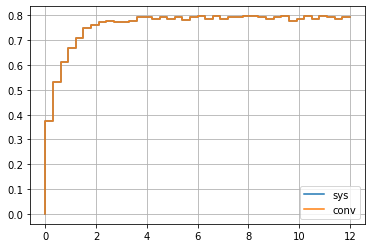

In [507]:
plt.step(useft, val[10:])
#plt.step(useft[:-(janela-1)], usefv2)
plt.step(useft, usefv)
plt.legend(['sys', 'conv', 'mva'], loc='lower right')

plt.grid(1)
plt.show()

### Procurando melhor reta para o método de Ziegler-Nichols

In [508]:
def calca(y1, y2, x1, x2):
    return (y2 - y1)/(x2 - x1)

def calcb(y, a, x):
    return y - a * x

In [509]:
besta = -1
bestb = -1
bestc = 1
for i in range(1, len(usefv)): #no vetor de amplitudes, testar todas as amplitudes
    nowa = calca(usefv[0], usefv[i], useft[0], useft[i])# calcular coeficiente angular
    nowb = calcb(usefv[0], nowa, useft[0]) #calcular coeficiente linear
    if math.isclose(nowa, 0., abs_tol=1e-05):
        continue
    c = 0
    for j in range(1, len(useft)): # testar para todos os pontos da curva (eixo tempo)
         ponto_reta = nowa * useft[j] + nowb # calcular amplitude
         if math.isclose(ponto_reta, usefv[j], rel_tol=1e-05, abs_tol=1e-05): # se forem iguais 
             c += 1
    #print(i, nowa, nowb, c)
    if(c > bestc): #atualiza os valores se este é o melhor resultado até agora
        besta = nowa
        bestb = nowb
        bestc = c
print("melhor resultado ->","a =", round(besta, 3), "b =", round(bestb, 3), "c =", bestc)
besta = 1.694
bestb = 0

melhor resultado -> a = -1 b = -1 c = 1


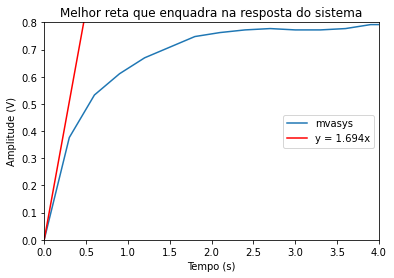

In [510]:
def vetor_reta(cang, coefb, vet_tempo):
    val1 = []
    for i in range(0, len(vet_tempo)):
        val1.append(cang * vet_tempo[i] + coefb)
    return val1

plt.plot(useft, usefv)
plt.plot(useft, vetor_reta(besta, bestb, useft), 'r')
plt.legend(['mvasys','y = ' + str(round(besta,3)) + 'x'],loc='center right')
plt.ylabel('Amplitude (V)')
plt.xlabel('Tempo (s)')
plt.title("Melhor reta que enquadra na resposta do sistema")

plt.xlim(0, 4)
plt.ylim(0, .8)
plt.show()

In [511]:
valores_estimados = []

## Modelos de identificação de sistemas

### Ziegler-Nichols

In [512]:
NAME = 'Ziegler-Nichols'
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [513]:
T = .8 / besta
T
T_zig = T

In [514]:
num = [k]
den = [T, 1]

In [515]:
sys = ct.tf(num, den)
sys

TransferFunction(array([1.]), array([0.47225502, 1.        ]))

In [516]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.47019698]), array([ 1.        , -0.52980302]), 0.3)

In [517]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

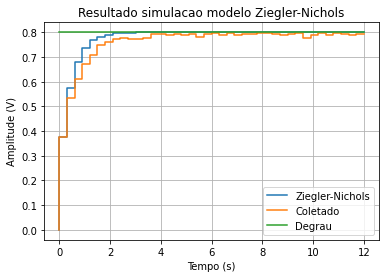

In [518]:
plotarGraficos(temp, amp, useft, usefv, NAME)

### Smith de primeira ordem

In [519]:
NAME = 'Smith de 1º ordem'
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [520]:
v1 = .28 * ESTADO_PERMANENTE
v2 = .632 * ESTADO_PERMANENTE
v1, v2

(0.22400000000000003, 0.5056)

In [521]:
k1 = acha_idx(v1, usefv)
k2 = acha_idx(v2, usefv)

In [522]:
t1, t2 = useft[k1], useft[k2]
T = 1.5 * (t2 - t1)
Td = t2 - T
T

0.44999999999999973

In [523]:
num = [k]
den = [T, 1]
num, den

([1.0], [0.44999999999999973, 1])

In [524]:
sys = ct.tf(num, den)
sys

TransferFunction(array([1.]), array([0.45, 1.  ]))

In [525]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.48658288]), array([ 1.        , -0.51341712]), 0.3)

In [526]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

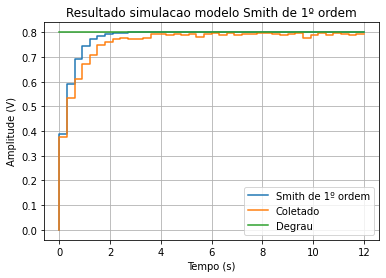

In [527]:
plotarGraficos(temp, amp, useft, usefv, NAME)

### Sundaresan-Krishnaswamy:

In [528]:
NAME = 'Sundaresan-Krishnaswamy'
v1 = .353 * ESTADO_PERMANENTE
v2 = .85 * ESTADO_PERMANENTE

In [529]:
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [530]:
k1 = acha_idx(v1, usefv)
k2 = acha_idx(v2, usefv)

In [531]:
t1, t2 = useft[k1], useft[k2]
T = .67 * (t2 - t1)
Td = 1.3 * t1 - .29 * t2
T, Td

(0.6030000000000003, 0.04199999999999976)

In [532]:
num = [k]
den = [T, 1]
num, den

([1.0], [0.6030000000000003, 1])

In [533]:
sys = ct.tf(num, den)
best_model = [[num],[den]]
sys

TransferFunction(array([1.]), array([0.603, 1.   ]))

In [534]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.39195868]), array([ 1.        , -0.60804132]), 0.3)

In [535]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

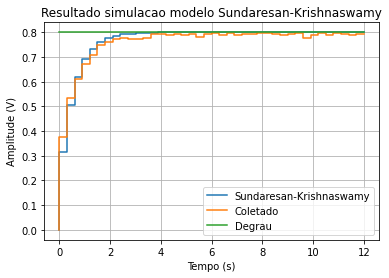

In [536]:
plotarGraficos(temp, amp, useft, usefv, NAME)

### Broida

In [537]:
NAME = 'Broida'
v1 = .28 * ESTADO_PERMANENTE
v2 = .4 * ESTADO_PERMANENTE

In [538]:
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [539]:
k1 = acha_idx(v1, usefv)
k2 = acha_idx(v2, usefv)
k2 += 1

In [540]:
t1, t2 = useft[k1], useft[k2]
T = 5.5 * (t2 - t1)
Td = t2 - T
T

1.649999999999999

In [541]:
num = [k]
den = [T, 1]
num, den

([1.0], [1.649999999999999, 1])

In [542]:
sys = ct.tf(num, den)
sys

TransferFunction(array([1.]), array([1.65, 1.  ]))

In [543]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.16624708]), array([ 1.        , -0.83375292]), 0.3)

In [544]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

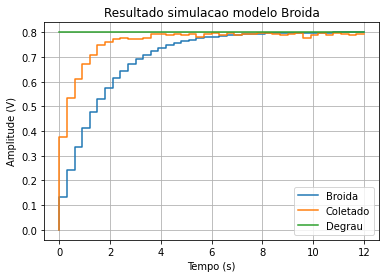

In [545]:
plotarGraficos(temp, amp, useft, usefv, NAME)

### Smith de segunda ordem

In [546]:
NAME = 'Smith de 2º ordem'
v1 = .2 * ESTADO_PERMANENTE
v2 = .6 * ESTADO_PERMANENTE

In [547]:
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [548]:
k1 = acha_idx(v1, usefv)
k2 = acha_idx(v2, usefv)

In [549]:
t20, t60 = useft[k1], useft[k2]
t20, t60

(0.0, 0.5999999999999996)

In [550]:
point = t20/t60
point

0.0

In [551]:
csi = .4
tau = 0.39999999999999997

num = [k]
den = [tau, 2 * csi * tau, 1]

In [552]:
sys = ct.tf(num, den)
sys

TransferFunction(array([1.]), array([0.4 , 0.32, 1.  ]))

In [553]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.10211082, 0.09420645]), array([ 1.        , -1.59031059,  0.78662786]), 0.3)

In [554]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

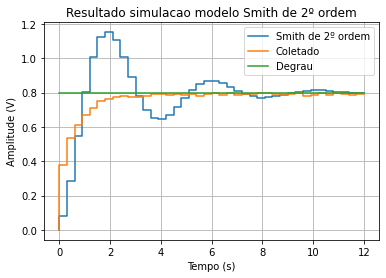

In [555]:
plotarGraficos(temp, amp, useft, usefv, NAME)

### Harriot

In [556]:
ESTADO_PERMANENTE = .8
AMP_DEGRAU = .8
v73 = .73 * ESTADO_PERMANENTE

In [557]:
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
NAME = 'Harriot'
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [558]:
k73 = acha_idx(v73, usefv)
print("idx =", k73," busquei =", v73, "achei =", usefv[k73], "no tempo =", useft[k73])

idx = 3  busquei = 0.584 achei = 0.61095 no tempo = 0.8999999999999999


In [559]:
t1 = useft[k73] / 2.6
t1

0.3461538461538461

In [560]:
k1 = acha_idx(t1, useft)
print("idx =", k1," busquei =", t1, "achei =", useft[k1], "no valor =", usefv[k1])
y1 = usefv[k1]
y1

idx = 1  busquei = 0.3461538461538461 achei = 0.2999999999999998 no valor = 0.37634


0.37634

In [561]:
ponto_h = y1/ESTADO_PERMANENTE
ponto_h

0.470425

Método fica por aqui porque o ponto nao existe no grafico

### Mollenkamp

In [562]:
NAME = 'Mollenkamp'
v1 = .15 * ESTADO_PERMANENTE
v2 = .45 * ESTADO_PERMANENTE
v3 = .75 * ESTADO_PERMANENTE

In [563]:
dy = ESTADO_PERMANENTE
du = AMP_DEGRAU
k = dy / du
dy, du, k

(0.8, 0.8, 1.0)

In [564]:
k1 = acha_idx(v1, usefv)
k2 = acha_idx(v2, usefv)
k3 = acha_idx(v3, usefv)

In [565]:
t1 = useft[k1]
t2 = useft[k2]
t3 = useft[k3]
t1, t2, t3

(0.0, 0.2999999999999998, 0.8999999999999999)

In [566]:
x = (t2 - t1) / (t3 - t1)
x

0.33333333333333315

In [567]:
qsi = (0.0805 - 5.547 * ((0.475 - x)**2))/(x-0.356)

f2 = 0
if qsi < 1:
    f2 = (0.708) * (2.811)**qsi
else:
    f2 = 2.6 * qsi-0.6

wn = f2 / (t3 - t1)

In [568]:
num = [k * wn * wn]
den = [1, 2 * qsi * wn, wn**2]

In [569]:
sys = ct.tf(num, den)
sys

TransferFunction(array([10.64088119]), array([ 1.        ,  8.87231914, 10.64088119]))

In [570]:
dsys = ctm.c2d(sys, TEMPO_AMOSTRAGEM, 'zoh')
dsys

TransferFunction(array([0.21943965, 0.0919468 ]), array([ 1.        , -0.75844326,  0.06982971]), 0.3)

In [571]:
temp, amp = ct.step_response(dsys, TEMPO_SIMULACAO)
amp *= AMP_DEGRAU
valores_estimados.append(amp)

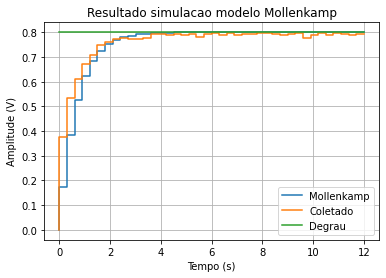

In [572]:
plotarGraficos(temp, amp, useft, usefv, NAME)

###**Estatística** 

In [573]:
n = len(valores_estimados)
modelos = ['Ziegler-Nichols', 'Smith de primeira ordem', 'Sundaresan', 'Broida', 'Smith de segunda ordem', 'Mollenkamp']
for i in range(n):
    print(modelos[i])
    calcula_estatistica(usefv, valores_estimados[i])
    print()

Ziegler-Nichols
NMRSE =  0.9684264755154914
r2 =  0.9727071109782998
pearson =  0.993140964690371

Smith de primeira ordem
NMRSE =  0.9649515981907705
r2 =  0.966368997010822
pearson =  0.9911563628108628

Sundaresan
NMRSE =  0.9778610086110007
r2 =  0.9865810342608722
pearson =  0.9965632927333264

Broida
NMRSE =  0.8517469375804959
r2 =  0.39825744209769676
pearson =  0.8922280882093037

Smith de segunda ordem
NMRSE =  0.8095871113011998
r2 =  0.0073501880531293695
pearson =  0.7851160427245049

Mollenkamp
NMRSE =  0.9414619630062765
r2 =  0.906183399730591
pearson =  0.9763690531784777



##**Sintonia do PID**


###Método de Ziegler

In [574]:
def PID_Z_N_sintony(transfer_func,T,D,K):
  kp = 1.2*T/(K*D)
  ti = 2*D
  td = D/2
  return kp,ti,td;

def PI_Z_N_sintony(transfer_func,T,D,K):
  kp = 0.9*T/(K*D)
  ti = 3.3*D
  return kp,ti

In [575]:
kp,ti,td = PID_Z_N_sintony(best_model,T_zig,.3,1) ## PID
print(f"Para o PID, pelo método de Ziegler o kp vale {kp}, o ti é igual {ti}, e o td é {td} ")

Para o PID, pelo método de Ziegler o kp vale 1.889020070838253, o ti é igual 0.6, e o td é 0.15 


In [576]:
kp,ti = PI_Z_N_sintony(best_model,T_zig,.3,1) ## PID
print(f"Para o PI, pelo método de Ziegler o kp vale {kp}, o ti é igual {ti}")

Para o PI, pelo método de Ziegler o kp vale 1.4167650531286897, o ti é igual 0.9899999999999999


In [577]:
best_model

[[[1.0]], [[0.6030000000000003, 1]]]

## Método de CHR sem sobrevalor

In [578]:
def PID_CHR_sintony(transfer_func,T,D,K):
  kp = 0.6*T/(K*D)
  ti = T
  td = D/2
  return kp,ti,td;

def PI_CHR_sintony(transfer_func,T,D,K):
  kp = 0.35*T/(K*D)
  ti = 1.16*D
  return kp,ti

In [579]:
kp,ti,td = PID_CHR_sintony(best_model,T_zig,.3,1) ## PID
print(f"Para o PID, pelo método de CHR o kp vale {kp}, o ti é igual {ti}, e o td é {td} ")

Para o PID, pelo método de CHR o kp vale 0.9445100354191265, o ti é igual 0.4722550177095632, e o td é 0.15 


In [580]:
kp,ti = PI_CHR_sintony(best_model,T_zig,.3,1) ## PID
print(f"Para o PID, pelo método de CHR o kp vale {kp}, o ti é igual {ti}, e o td é {td} ")

Para o PID, pelo método de CHR o kp vale 0.5509641873278237, o ti é igual 0.348, e o td é 0.15 


## Método CHR 20% sobresinal

In [581]:
def PID_CHR_sintony_20(transfer_func,T,D,K):
  kp = 0.95*T/(K*D)
  ti = 1.357*T
  td = 0.473*D
  return kp,ti,td;

def PI_CHR_sintony_20(transfer_func,T,D,K):
  kp = 0.6*T/(K*D)
  ti = D
  return kp,ti

In [582]:
kp,ti,td = PID_CHR_sintony_20(best_model,T_zig,.3,1) ## PID
print(f"Para o PID, pelo método de CHR o kp vale {kp}, o ti é igual {ti}, e o td é {td} ")

Para o PID, pelo método de CHR o kp vale 1.49547422274695, o ti é igual 0.6408500590318772, e o td é 0.1419 


In [583]:
kp,ti = PI_CHR_sintony_20(best_model,T_zig,.3,1) ## PID
print(f"Para o PID, pelo método de CHR o kp vale {kp}, o ti é igual {ti} ")

Para o PID, pelo método de CHR o kp vale 0.9445100354191265, o ti é igual 0.3 
